In [1]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
tf.__version__

'2.12.0'

## Download data

In [3]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')

In [4]:
data_dir

WindowsPath('C:/Users/tsoam/.keras/datasets/flower_photos')

In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


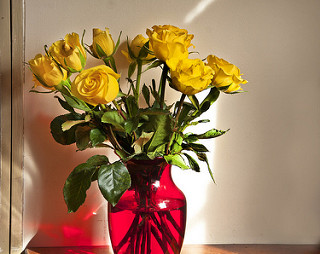

In [6]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[13]))

## Load data using Keras utility

In [7]:
batch_size = 32
img_height = 180
img_width = 180

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [9]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Visualise the dataset

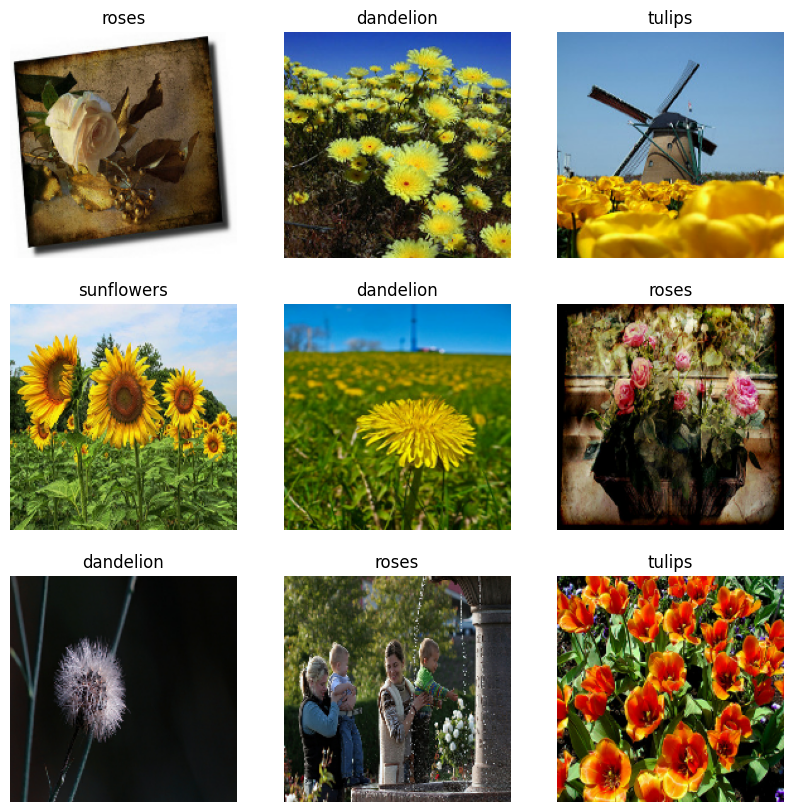

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [12]:
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)

(32, 180, 180, 3)
(32,)


## Configure the dataset for performance

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Model Definition

In [14]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
    
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
    
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
    
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

## Train the model

In [17]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 35s 351ms/step - loss: 1.3511 - accuracy: 0.4292 - val_loss: 1.0522 - val_accuracy: 0.5749
Epoch 2/10
92/92 [==============================] - 34s 371ms/step - loss: 1.0053 - accuracy: 0.6087 - val_loss: 0.9460 - val_accuracy: 0.6390
Epoch 3/10
92/92 [==============================] - 42s 455ms/step - loss: 0.7861 - accuracy: 0.7105 - val_loss: 0.9503 - val_accuracy: 0.6322
Epoch 4/10
92/92 [==============================] - 42s 456ms/step - loss: 0.5663 - accuracy: 0.7922 - val_loss: 0.9522 - val_accuracy: 0.6553
Epoch 5/10
92/92 [==============================] - 42s 459ms/step - loss: 0.3597 - accuracy: 0.8713 - val_loss: 1.0192 - val_accuracy: 0.6485
Epoch 6/10
92/92 [==============================] - 42s 460ms/step - loss: 0.2155 - accuracy: 0.9275 - val_loss: 1.2642 - val_accuracy: 0.6240
Epoch 7/10
92/92 [==============================] - 44s 475ms/step - loss: 0.1173 - accuracy: 0.9659 - val_loss: 1.2827 - val_accuracy: 0.6689

## Visualise the results

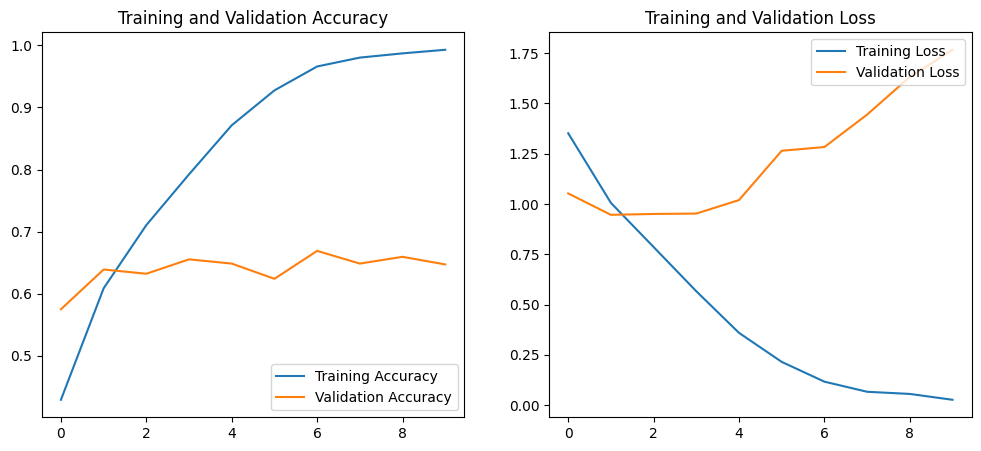

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Data Augmentation

In [19]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

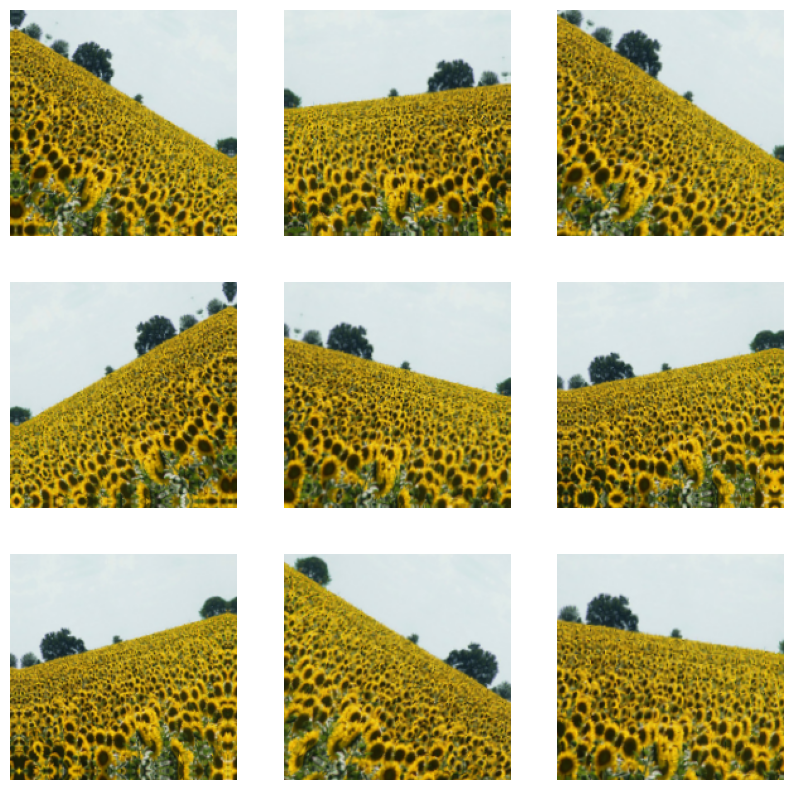

In [20]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## Model with dropout and data augmentation

In [21]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
    
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
    
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
    
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
    
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [24]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 55s 578ms/step - loss: 1.4285 - accuracy: 0.3835 - val_loss: 1.1544 - val_accuracy: 0.5068
Epoch 2/15
92/92 [==============================] - 51s 554ms/step - loss: 1.1254 - accuracy: 0.5293 - val_loss: 1.0458 - val_accuracy: 0.5790
Epoch 3/15
92/92 [==============================] - 49s 535ms/step - loss: 0.9890 - accuracy: 0.6117 - val_loss: 0.9275 - val_accuracy: 0.6213
Epoch 4/15
92/92 [==============================] - 49s 528ms/step - loss: 0.9016 - accuracy: 0.6434 - val_loss: 0.8709 - val_accuracy: 0.6485
Epoch 5/15
92/92 [==============================] - 48s 519ms/step - loss: 0.8650 - accuracy: 0.6594 - val_loss: 0.8860 - val_accuracy: 0.6458
Epoch 6/15
92/92 [==============================] - 48s 522ms/step - loss: 0.8047 - accuracy: 0.6812 - val_loss: 0.8284 - val_accuracy: 0.6744
Epoch 7/15
92/92 [==============================] - 48s 517ms/step - loss: 0.7822 - accuracy: 0.7044 - val_loss: 0.9458 - val_accuracy: 0.6362

## Result Visualization

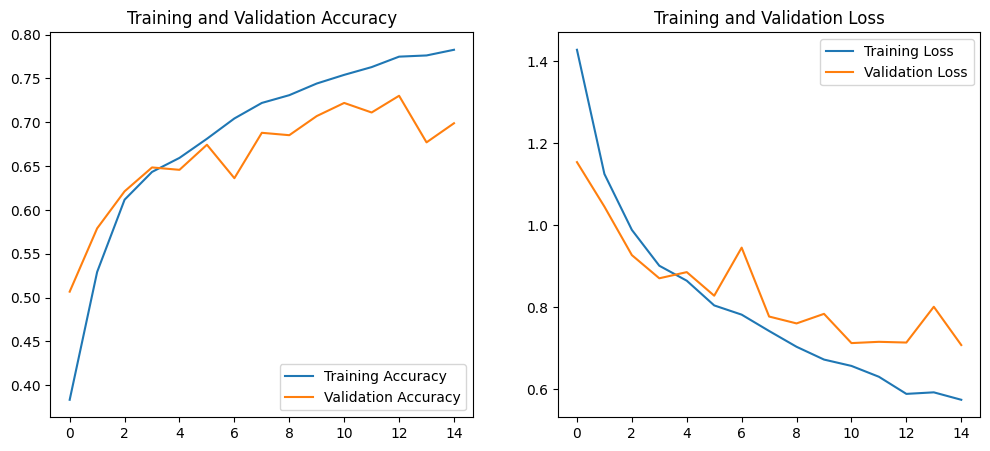

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Prediction on new data

In [26]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 125ms/step
This image most likely belongs to sunflowers with a 88.60 percent confidence.
